## EP4130 - Data Science Analysis Project

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
import scipy.stats as stats

## Loading the Data

In [80]:
data = pd.read_csv('nbaallelo.csv')
display(data)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126309,63155,201506110CLE,NBA,0,2015,6/11/2015,100,1,CLE,Cavaliers,...,60.309792,GSW,Warriors,103,1790.9591,1809.9791,H,L,0.546572,NaN
126310,63156,201506140GSW,NBA,0,2015,6/14/2015,102,1,GSW,Warriors,...,68.013329,CLE,Cavaliers,91,1704.3949,1700.7391,H,W,0.765565,NaN
126311,63156,201506140GSW,NBA,1,2015,6/14/2015,101,1,CLE,Cavaliers,...,60.010067,GSW,Warriors,104,1809.9791,1813.6349,A,L,0.234435,NaN
126312,63157,201506170CLE,NBA,0,2015,6/16/2015,102,1,CLE,Cavaliers,...,59.290245,GSW,Warriors,105,1813.6349,1822.2881,H,L,0.481450,NaN


In [81]:
E1 = np.array(data['elo_i'])
E2 = np.array(data['opp_elo_i'])
E_diff = E1 - E2
P = np.array(data['pts'] - data['opp_pts'])


loc_dict = {'A': -1, 'H': 1, 'N': 0}
loc = np.array([loc_dict[x] for x in data['game_location']])

game_result = list(data['game_result'])

print(f'\nLocation set = {set(loc)}')
print(f'Game results set = {set(game_result)}')
print(f'\nMax Elo = {E1.max()} \nMin Elo = {E2.min()}')
print(f'Max Elo diff = {abs(E1 - E2).max()} \nMin Elo diff = {abs(E1 - E2).min()}')

inputs_np = np.stack((E1, E2, E_diff, loc), axis = 1)
print(f'Input shape: {inputs_np.shape}')


Location set = {0, 1, -1}
Game results set = {'W', 'L'}

Max Elo = 1853.1045 
Min Elo = 1091.6445
Max Elo diff = 572.1608999999999 
Min Elo diff = 0.0
Input shape: (126314, 4)


## Defining classes for the different models

In [82]:
class GaussianModel_Linear(nn.Module):
    def __init__(self):
        super(GaussianModel_Linear, self).__init__()
        self.mean_linear = nn.Linear(4, 1)  # 4 input features: E1, E2, E_diff, loc
        init.trunc_normal_(self.mean_linear.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.mean_linear.bias, std=0.1, a=0.0)
        
        self.variance_linear = nn.Linear(4, 1)  # 4 input features: E1, E2, E_diff, loc
        init.trunc_normal_(self.variance_linear.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.variance_linear.bias, std=0.1, a=0.0)
        
    def forward(self, inputs):
        mean = self.mean_linear(inputs)
        variance = nn.functional.relu(self.variance_linear(inputs))

        return mean, variance

In [83]:
class GaussianModel_Quadratic(nn.Module):
    def __init__(self):
        super(GaussianModel_Quadratic, self).__init__()
        
        self.mean_quadratic = nn.Linear(7, 1)  # 10 terms : 9 quadratic + 1 loc
        init.trunc_normal_(self.mean_quadratic.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.mean_quadratic.bias, std=0.1, a=0.0)
        
        self.variance_quadratic = nn.Linear(7, 1)  # 10 terms : 9 quadratic + 1 loc
        init.trunc_normal_(self.variance_quadratic.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.variance_quadratic.bias, std=0.1, a=0.0)
        
    def forward(self, inputs):
        x = inputs[:, 0].unsqueeze(1)
        y = inputs[:, 1].unsqueeze(1)
        z = inputs[:, 2].unsqueeze(1)
        quad_inputs = torch.hstack([inputs, x**2, y**2, x*y])
        
        mean = self.mean_quadratic(quad_inputs)
        variance = nn.functional.relu(self.variance_quadratic(quad_inputs))

        return mean, variance

In [84]:
class GaussianModel_Quadratic2(nn.Module):
    def __init__(self):
        super(GaussianModel_Quadratic2, self).__init__()
        
        self.mean_quadratic = nn.Linear(7, 1)  # 10 terms : 9 quadratic + 1 loc
        init.trunc_normal_(self.mean_quadratic.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.mean_quadratic.bias, std=0.1, a=0.0)
        
        self.variance_quadratic = nn.Linear(7, 1)  # 10 terms : 9 quadratic + 1 loc
        init.trunc_normal_(self.variance_quadratic.weight, std=0.1, a=0.0)
        init.trunc_normal_(self.variance_quadratic.bias, std=0.1, a=0.0)
        
    def forward(self, inputs):
        x = inputs[:, 0].unsqueeze(1)
        y = inputs[:, 1].unsqueeze(1)
        z = inputs[:, 2].unsqueeze(1)
        quad_inputs = torch.hstack([inputs, z**2, x*z, y*z])
        
        mean = self.mean_quadratic(quad_inputs)
        variance = nn.functional.relu(self.variance_quadratic(quad_inputs))
        return mean, variance

In [85]:
class GaussianModel_General(nn.Module):
    def __init__(self):
        super(GaussianModel_General, self).__init__()
        self.mean_function = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        ) 
        
        self.variance_function = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )  
        
        self.positive_init(self.mean_function)
        self.positive_init(self.variance_function)

    def positive_init(self, layers):
        for l in layers:
             if isinstance(l, nn.Linear):
                nn.init.uniform_(l.weight, a=0.1, b=50.)
                nn.init.uniform_(l.bias, a=0.1, b=50. )
                    
    def forward(self, inputs):
        mean = self.mean_function(inputs)
        variance = nn.functional.relu(self.variance_function(inputs))

        return mean, variance

## Training Functions

In [86]:
# Negative log likelihood loss function
def negative_log_likelihood(y_true, mean, variance):
    return torch.mean(0.5 * torch.log(2 * torch.tensor(np.pi) * variance) + \
                      0.5 * ((y_true - mean)**2) / variance)

Bins: [-68.  -54.4 -40.8 -27.2 -13.6   0.   13.6  27.2  40.8  54.4  68. ]


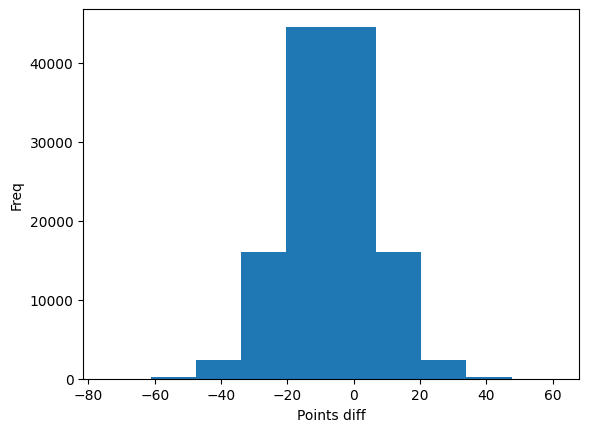

In [87]:
# Plotting the histogram of P
P_weights, P_bins = np.histogram(P)
print(f'Bins: {P_bins}')
plt.bar(P_bins[:-1], P_weights, width=P_bins[1] - P_bins[0])
plt.xlabel('Points diff')
plt.ylabel('Freq')
plt.show()

In [88]:
np.digitize([-68, -67, 55, 68], P_bins)


array([ 1,  1, 10, 11])

In [89]:
# Negative log likelihood loss function weighted according the points-diff histogram
def weighted_negative_log_likelihood(y_true, mean, variance, scale=100):
    loss = 0.5 * torch.log(2 * torch.tensor(np.pi) * variance) + \
                      0.5 * ((y_true - mean)**2) / variance

    
    bin_indices = np.digitize(y_true.cpu(), P_bins, right=True) - 1
    bin_weights = 1 / P_weights
    bin_weights = bin_weights / bin_weights.sum()
    weights = scale*torch.tensor(bin_weights[bin_indices]).to(device)
    
    return torch.sum(loss*weights)

In [90]:
def train(model, checkpoint_pth, num_epochs=10, lr=0.01, weighted_loss=False):
    
    start_time = time.time()
    
    num_epochs = num_epochs
    epoch = 0
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    model = model.to(device)

    # Loading checkpoint
    try:
        checkpoint = torch.load(checkpoint_pth)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch'] + 1
        print(f'Checkpoint {checkpoint_pth} loaded succesfully')
    except:
        print(f'Checkpoint {checkpoint_pth} does not exist')
    
    for epoch in range(epoch, num_epochs):
        total_loss = 0
        for batch_inputs, batch_pts in dataloader:

            # Forward pass
            mean, variance = model(batch_inputs)
            
            # Compute loss and update params
            if weighted_loss:
                loss = weighted_negative_log_likelihood(batch_pts, mean, variance)
            else:
                loss = negative_log_likelihood(batch_pts, mean, variance)            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.detach().item()

        avg_loss = total_loss / len(inputs)         
        print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}')
        
        # Save checkpoint after every epoch
        if not math.isnan(avg_loss):
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'avg_loss': avg_loss
            }, checkpoint_pth)

    end_time = time.time()
    total_time = (end_time - start_time) / 60.
    print(f'Total execution time = {total_time} minutes')

## Training the models

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

inputs = torch.from_numpy(inputs_np).float()
inputs = inputs.to(device)
pts = torch.from_numpy(P).float().unsqueeze(1)
pts = pts.to(device)

# Creating a dataloader
batch_size = 256
dataset = TensorDataset(inputs, pts)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = cuda


In [92]:
linear_model = GaussianModel_Linear()
train(linear_model, 'linear_model_1.pt', num_epochs=20)

Checkpoint linear_model_1.pt loaded succesfully
Total execution time = 5.593299865722656e-05 minutes


In [93]:
linear_model_w = GaussianModel_Linear()
train(linear_model_w, 'linear_model_w.pt', num_epochs=30, weighted_loss=True)

Checkpoint linear_model_w.pt loaded succesfully
Total execution time = 5.369186401367187e-05 minutes


In [94]:
quadratic_model = GaussianModel_Quadratic()
train(quadratic_model, 'quadratic_lr3_wd.pt', num_epochs=20, lr=0.001)

Checkpoint quadratic_lr3_wd.pt loaded succesfully
Total execution time = 5.199114481608073e-05 minutes


In [95]:
general_model = GaussianModel_General()
train(general_model, 'general_lr3_wd_w1.pt', num_epochs=10, lr=0.001)

Checkpoint general_lr3_wd_w1.pt loaded succesfully
Total execution time = 9.142160415649414e-05 minutes


## Testing functions

In [96]:
# Function that plots the output point-difference distribution
def point_distribution_output(model, elo_input, display=True):
    with torch.no_grad():
        mean, variance = model(elo_input.unsqueeze(0))
        mean, variance = mean.cpu().squeeze(), variance.cpu().squeeze()
        print(f'Mean = {mean}')
        print(f'Variance = {variance}')
        print(f'Std = {np.sqrt(variance)}')
        print(f'E1 = {elo_input[0]}, E2 = {elo_input[1]}, E_diff = {elo_input[2]}, Loc = {elo_input[3]}')
        
        if display:
            distr = stats.norm(mean, np.sqrt(variance))
            x_axis = np.linspace(-100, 100, 1000)
            pdf = distr.pdf(x_axis)
            plt.plot(x_axis, pdf)
            plt.show()

### Predicting win probabilities: Comparing the Model against Elo Curve

In [97]:
def predict_win_elo(x):
    E_diff = x[:, 2].cpu()
    return 1 - 1/(1 + np.exp(0.00583*E_diff - 0.0505))

In [98]:
def predict_win_model(model, elo_input, show_stats=True):
    with torch.no_grad():
        mean, variance = model(elo_input)
        mean, variance = mean.cpu(), variance.cpu()
        distr = stats.norm(mean, np.sqrt(variance))
    win_prob = torch.tensor(1.0 - distr.cdf(0)).squeeze()
    
    if show_stats:
        print("Stats for the model's predictions:")
        print(f'Max = {win_prob.max():.4f}')
        print(f'Min = {win_prob.min():.4f}')
        print(f'Mean = {win_prob.mean():.4f}\n')
    return win_prob

*compare_with_elo()* 
- This function compares the output given the model and elo for all datapoints.
- Outputs the mean absolute deviation

In [99]:
def compare_with_elo(model):
    p_elo = predict_win_elo(inputs)
    p_model = predict_win_model(model, inputs)
    
    score = torch.mean(torch.abs(p_elo - p_model))
    
    print(f'Average of {score*100:.2f}% deviation from Elo-prediction')
    print(f'Max deviation {torch.max(torch.abs(p_elo - p_model)*100):.2f}')
    print(f'Min deviation {torch.min(torch.abs(p_elo - p_model)*100):.2f}')
    print(f'Median deviation {torch.median(torch.abs(p_elo - p_model)*100):.2f}')
    
    plt.hist(np.array(100*torch.abs(p_elo - p_model).cpu()), bins=20)
    plt.title('Absolute deviation from p_elo')
    plt.xlabel('|p_elo - p_model|')
    plt.ylabel('freq')
    plt.show()

### Predicting win probabilities: Comparing against data in each bin

In [100]:
# Checks the number of samples in each bin of E1 vs E2 at a given location
def counter():
    E_ranges = np.arange(1000, 1900, 100)
    results = np.array([[0, 0, 0, 0]])
    print(E_ranges)
    for E1_range in E_ranges:
        for E2_range in E_ranges:
            count_A = 0
            count_H = 0
            count_N = 0
            E1_beg, E1_end = E1_range - 50, E1_range + 50
            E2_beg, E2_end = E2_range - 50, E2_range + 50

            for e1, e2, e_diff, l in zip(E1, E2, E1 - E2, loc):
                if e1 < E1_beg or e1 > E1_end or e2 < E2_beg or e2 > E2_end:
                    continue
                if l == -1:
                    count_A += 1
                elif l == 1:
                    count_H += 1
                else:
                    count_N += 1

            results = np.vstack((results, np.array([E1_range, E2_range, -1, count_A]), \
                                        np.array([E1_range, E2_range, 1, count_H]), \
                                        np.array([E1_range, E2_range, 0, count_N])))
            
    print('Finished!')
    return results
results = counter()

[1000 1100 1200 1300 1400 1500 1600 1700 1800]
Finished!


In [101]:
sorted_indices = np.argsort(results[:, -1])[::-1]
sorted_results = results[sorted_indices, :]
top_results = sorted_results[:20, :]
print(f'Top frequencies of elements in different subsets of the dataset: \n')
print('   E1,  E2,  loc, freq')
print(top_results)

Top frequencies of elements in different subsets of the dataset: 

   E1,  E2,  loc, freq
[[1500 1500    1 7395]
 [1500 1500   -1 7395]
 [1600 1500    1 5193]
 [1500 1600   -1 5193]
 [1500 1600    1 5063]
 [1600 1500   -1 5063]
 [1500 1400    1 4906]
 [1400 1500   -1 4906]
 [1500 1400   -1 4882]
 [1400 1500    1 4882]
 [1600 1600    1 4252]
 [1600 1600   -1 4252]
 [1400 1400   -1 3451]
 [1400 1400    1 3451]
 [1600 1400   -1 3435]
 [1400 1600    1 3435]
 [1400 1600   -1 3414]
 [1600 1400    1 3414]
 [1500 1300   -1 1735]
 [1300 1500    1 1735]]


In [102]:
# Gets the empirical win probability of E1 vs E2 in a given location from the data
def get_p_from_data(E1_mid, E2_mid, location):
    E1_beg, E1_end = E1_mid - 50, E1_mid + 50
    E2_beg, E2_end = E2_mid - 50, E2_mid + 50
    
    total_games = 0
    win_count = 0
    for e1, e2, e_diff, l, res in zip(E1, E2, E1 - E2, loc, game_result):
        if e1 < E1_beg or e1 > E1_end or e2 < E2_beg or e2 > E2_end:
            continue
        if l != location:
            continue
        
        total_games += 1
        win_count += 1 if res == 'W' else 0
        
    # print(f'Total games = {total_games}')
    # print(f'Win count = {win_count}')
          
    return win_count/total_games

In [103]:
# Compares the win probabilities computed by the data, model and elo curve
def compare(model, E1_mid, E2_mid, location):
    p_true = get_p_from_data(E1_mid, E2_mid, location)
    
    elo_input = torch.tensor([E1_mid, E2_mid, E1_mid - E2_mid, location]).to(device).float().unsqueeze(0)
    p_elo = predict_win_elo(elo_input).cpu().item()
    p_model = predict_win_model(model, elo_input, show_stats=False).cpu().item()
    
    # print(f'\n Win probability:')
    # print(f'From data = {p_true:.4f}')
    # print(f'From our model = {p_model:.4f}')
    # print(f'From elo curve = {p_elo:.4f}')
    
    return [p_true, p_model, p_elo]

In [104]:
def compare_all(model):
    comparison_results = []
    for item in top_results:
        E1_mid, E2_mid, location, _ = item
        comparison_results.append(compare(model, E1_mid, E2_mid, location))
        
    comparison_results = np.array(comparison_results)
       
    model_diff = np.mean(np.abs(comparison_results[:, 0] - comparison_results[:, 1]))
    elo_diff = np.mean(np.abs(comparison_results[:, 0] - comparison_results[:, 2]))
          
    print(f'Mean Deviation from data:')
    print(f'Model = {model_diff:.4f}')
    print(f'Elo curve = {elo_diff:.4f}')
    
    print('\n   Data,      Model,     Elo')
    print(comparison_results)

## Testing

### Testing against the bin-wise data

In [105]:
compare_all(linear_model)

Mean Deviation from data:
Model = 0.0432
Elo curve = 0.1277

   Data,      Model,     Elo
[[0.64503043 0.65610965 0.4873777 ]
 [0.35496957 0.41828971 0.4873777 ]
 [0.75101098 0.73919144 0.63006604]
 [0.24898902 0.32527819 0.34671736]
 [0.5251827  0.5602562  0.34671736]
 [0.4748173  0.5193867  0.63006604]
 [0.74643294 0.74382208 0.63006604]
 [0.25356706 0.31722046 0.34671736]
 [0.49365014 0.51732491 0.63006604]
 [0.50634986 0.55958067 0.34671736]
 [0.6505174  0.65384807 0.4873777 ]
 [0.3494826  0.42338276 0.4873777 ]
 [0.37786149 0.41277196 0.4873777 ]
 [0.62213851 0.65868683 0.4873777 ]
 [0.6349345  0.61534094 0.75315303]
 [0.3650655  0.45787918 0.22855294]
 [0.15817223 0.23351145 0.22855294]
 [0.84182777 0.81295137 0.75315303]
 [0.63861671 0.61647207 0.75315303]
 [0.36138329 0.45352738 0.22855294]]


In [106]:
compare_all(linear_model_w)

Mean Deviation from data:
Model = 0.0316
Elo curve = 0.1277

   Data,      Model,     Elo
[[0.64503043 0.63734699 0.4873777 ]
 [0.35496957 0.39871496 0.4873777 ]
 [0.75101098 0.73418487 0.63006604]
 [0.24898902 0.31024766 0.34671736]
 [0.5251827  0.53144138 0.34671736]
 [0.4748173  0.50019283 0.63006604]
 [0.74643294 0.74153014 0.63006604]
 [0.25356706 0.30483731 0.34671736]
 [0.49365014 0.50004241 0.63006604]
 [0.50634986 0.53232823 0.34671736]
 [0.6505174  0.63318365 0.4873777 ]
 [0.3494826  0.40181163 0.4873777 ]
 [0.37786149 0.39532641 0.4873777 ]
 [0.62213851 0.64194853 0.4873777 ]
 [0.6349345  0.60619563 0.75315303]
 [0.3650655  0.4289318  0.22855294]
 [0.15817223 0.23004265 0.22855294]
 [0.84182777 0.8256087  0.75315303]
 [0.63861671 0.60977075 0.75315303]
 [0.36138329 0.42647324 0.22855294]]


In [107]:
compare_all(quadratic_model)

Mean Deviation from data:
Model = 0.1543
Elo curve = 0.1277

   Data,      Model,     Elo
[[0.64503043 0.49473611 0.4873777 ]
 [0.35496957 0.49340366 0.4873777 ]
 [0.75101098 0.50080178 0.63006604]
 [0.24898902 0.51358615 0.34671736]
 [0.5251827  0.51485007 0.34671736]
 [0.4748173  0.49948536 0.63006604]
 [0.74643294 0.49582729 0.63006604]
 [0.25356706 0.48649183 0.34671736]
 [0.49365014 0.49441811 0.63006604]
 [0.50634986 0.48784136 0.34671736]
 [0.6505174  0.5112928  0.4873777 ]
 [0.3494826  0.51004397 0.4873777 ]
 [0.37786149 0.47676783 0.4873777 ]
 [0.62213851 0.47819339 0.4873777 ]
 [0.6349345  0.51094431 0.75315303]
 [0.3650655  0.51787224 0.22855294]
 [0.15817223 0.51659199 0.22855294]
 [0.84182777 0.51233605 0.75315303]
 [0.63861671 0.52051528 0.75315303]
 [0.36138329 0.48007075 0.22855294]]


In [108]:
compare_all(general_model)

Mean Deviation from data:
Model = 0.1553
Elo curve = 0.1277

   Data,      Model,     Elo
[[0.64503043 0.5005349  0.4873777 ]
 [0.35496957 0.49769993 0.4873777 ]
 [0.75101098 0.50096489 0.63006604]
 [0.24898902 0.49799501 0.34671736]
 [0.5251827  0.50081598 0.34671736]
 [0.4748173  0.49819554 0.63006604]
 [0.74643294 0.50027864 0.63006604]
 [0.25356706 0.49717515 0.34671736]
 [0.49365014 0.49742125 0.63006604]
 [0.50634986 0.5000898  0.34671736]
 [0.6505174  0.50122847 0.4873777 ]
 [0.3494826  0.49847582 0.4873777 ]
 [0.37786149 0.49686366 0.4873777 ]
 [0.62213851 0.49979826 0.4873777 ]
 [0.6349345  0.49792955 0.75315303]
 [0.3650655  0.50036095 0.22855294]
 [0.15817223 0.49746998 0.22855294]
 [0.84182777 0.50071986 0.75315303]
 [0.63861671 0.49711432 0.75315303]
 [0.36138329 0.49961867 0.22855294]]


### Testing model vs Elo curve

Stats for the model's predictions:
Max = 0.9624
Min = 0.0343
Mean = 0.5332

Average of 11.31% deviation from Elo-prediction
Max deviation 23.75
Min deviation 0.00
Median deviation 11.20


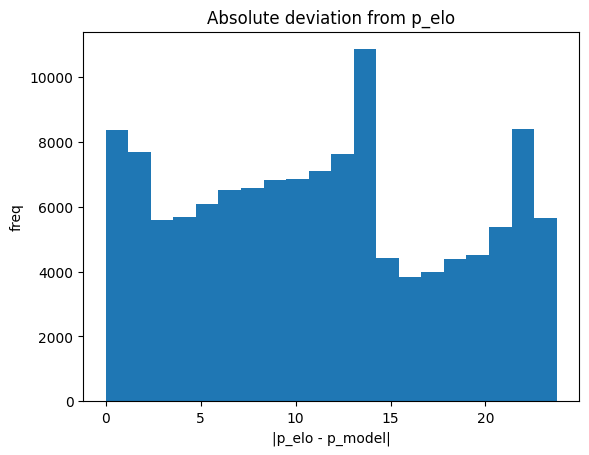

In [109]:
compare_with_elo(linear_model)

Stats for the model's predictions:
Max = 0.9897
Min = 0.0581
Mean = 0.5205

Average of 11.31% deviation from Elo-prediction
Max deviation 20.60
Min deviation 0.00
Median deviation 11.95


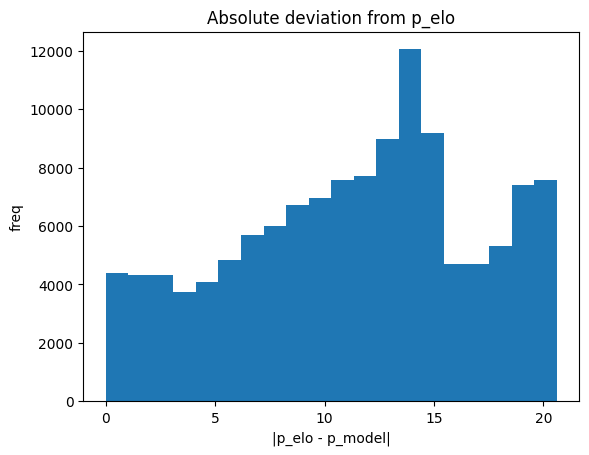

In [110]:
compare_with_elo(linear_model_w)

Stats for the model's predictions:
Max = 0.7320
Min = 0.3942
Mean = 0.5050

Average of 15.65% deviation from Elo-prediction
Max deviation 62.09
Min deviation 0.00
Median deviation 14.26


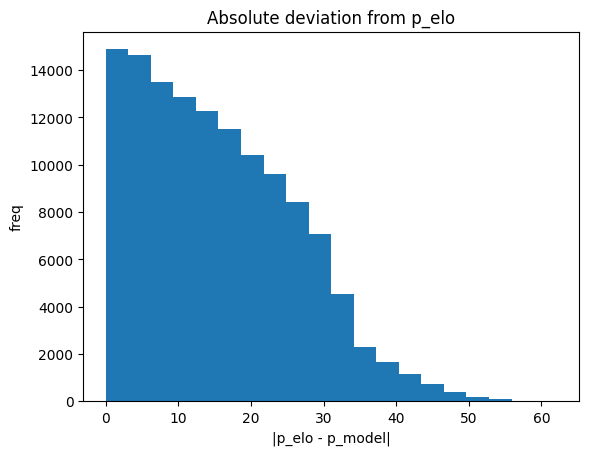

In [111]:
compare_with_elo(quadratic_model)

Stats for the model's predictions:
Max = 1.0000
Min = 0.4941
Mean = 0.4991

Average of 15.65% deviation from Elo-prediction
Max deviation 96.73
Min deviation 0.00
Median deviation 14.23


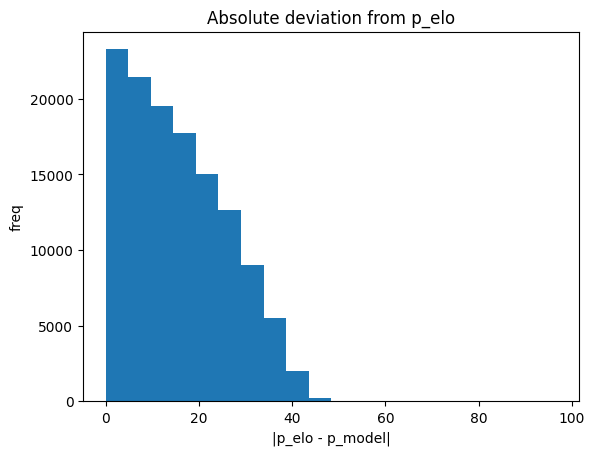

In [112]:
compare_with_elo(general_model)

## Points distribution curves predicted by the linear model

**Observations:**
- Different means observed
- Std dev ~ 12 points

Mean = 4.026162147521973
Variance = 161.23855590820312
Std = 12.69797420501709
E1 = 1560.359375, E2 = 1593.23876953125, E_diff = -32.879398345947266, Loc = 1.0


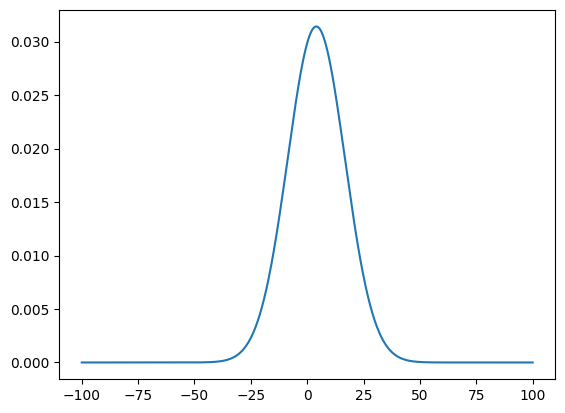

In [113]:
point_distribution_output(linear_model, inputs[6000, :].to(device), display=True)

Mean = 2.3525166511535645
Variance = 158.00865173339844
Std = 12.570149421691895
E1 = 1564.7388916015625, E2 = 1407.879638671875, E_diff = 156.8592987060547, Loc = -1.0


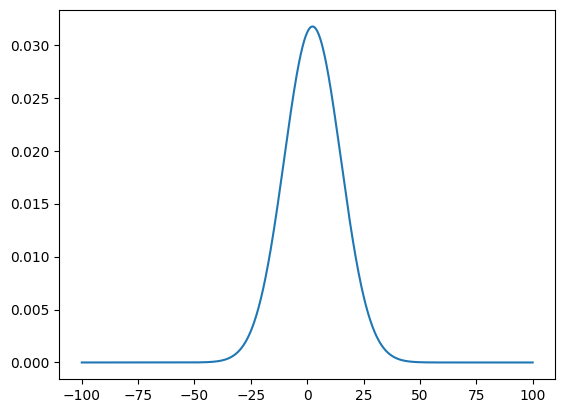

In [114]:
point_distribution_output(linear_model, inputs[8000, :].to(device), display=True)

Mean = -1.2470983266830444
Variance = 148.68167114257812
Std = 12.193509101867676
E1 = 1407.03173828125, E2 = 1605.9410400390625, E_diff = -198.9093017578125, Loc = 1.0


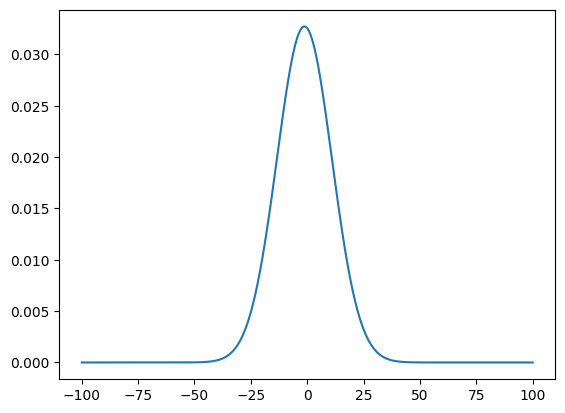

In [115]:
point_distribution_output(linear_model, inputs[10000, :].to(device), display=True)

Mean = 4.827242374420166
Variance = 134.0437774658203
Std = 11.577727317810059
E1 = 1300.0, E2 = 1300.0, E_diff = 0.0, Loc = 1.0


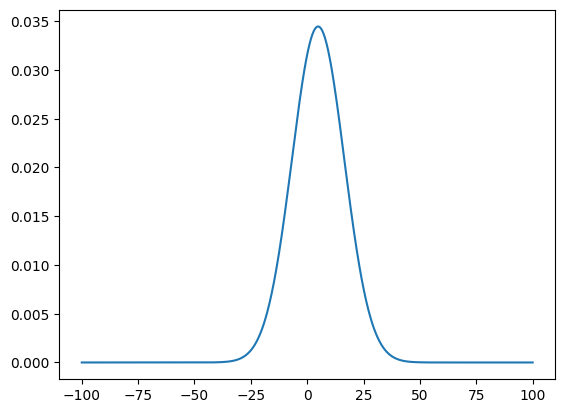

In [116]:
point_distribution_output(linear_model, inputs[0, :].to(device), display=True)